If you encounter the following error in Colab, you can restart the runtime to execute the following cells correctly.

```
xtcocotools/_mask.pyx in init xtcocotools._mask()
ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 88 from C header, got 80 from PyObject
```

In [1]:
#@title import packages

import anime_face_detector
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#@title Contour Definition
FACE_BOTTOM_OUTLINE = np.arange(0, 5)
LEFT_EYEBROW = np.arange(5, 8)
RIGHT_EYEBROW = np.arange(8, 11)
LEFT_EYE_TOP = np.arange(11, 14)
LEFT_EYE_BOTTOM = np.arange(14, 17)
RIGHT_EYE_TOP = np.arange(17, 20)
RIGHT_EYE_BOTTOM = np.arange(20, 23)
NOSE = np.array([23])
MOUTH_OUTLINE = np.arange(24, 28)

FACE_OUTLINE_LIST = [FACE_BOTTOM_OUTLINE, LEFT_EYEBROW, RIGHT_EYEBROW]
LEFT_EYE_LIST = [LEFT_EYE_TOP, LEFT_EYE_BOTTOM]
RIGHT_EYE_LIST = [RIGHT_EYE_TOP, RIGHT_EYE_BOTTOM]
NOSE_LIST = [NOSE]
MOUTH_OUTLINE_LIST = [MOUTH_OUTLINE]

# (indices, BGR color, is_closed)
CONTOURS = [
    (FACE_OUTLINE_LIST, (0, 170, 255), False),
    (LEFT_EYE_LIST, (50, 220, 255), False),
    (RIGHT_EYE_LIST, (50, 220, 255), False),
    (NOSE_LIST, (255, 30, 30), False),
    (MOUTH_OUTLINE_LIST, (255, 30, 30), True),
]

In [3]:
#@title Visualization Function
def visualize_box(image,
                  box,
                  score,
                  lt,
                  box_color=(0, 255, 0),
                  text_color=(255, 255, 255),
                  show_box_score=True):
    cv2.rectangle(image, tuple(box[:2]), tuple(box[2:]), box_color, lt)
    if not show_box_score:
        return
    cv2.putText(image,
                f'{round(score * 100, 2)}%', (box[0], box[1] - 2),
                0,
                lt / 2,
                text_color,
                thickness=max(lt, 1),
                lineType=cv2.LINE_AA)


def visualize_landmarks(image, pts, lt, landmark_score_threshold):
    for *pt, score in pts:
        pt = tuple(np.round(pt).astype(int))
        if score < landmark_score_threshold:
            color = (0, 255, 255)
        else:
            color = (0, 0, 255)
        cv2.circle(image, pt, lt, color, cv2.FILLED)


def draw_polyline(image, pts, color, closed, lt, skip_contour_with_low_score,
                  score_threshold):
    if skip_contour_with_low_score and (pts[:, 2] < score_threshold).any():
        return
    pts = np.round(pts[:, :2]).astype(int)
    cv2.polylines(image, np.array([pts], dtype=np.int32), closed, color, lt)


def visualize_contour(image, pts, lt, skip_contour_with_low_score,
                      score_threshold):
    for indices_list, color, closed in CONTOURS:
        for indices in indices_list:
            draw_polyline(image, pts[indices], color, closed, lt,
                          skip_contour_with_low_score, score_threshold)


def visualize(image: np.ndarray,
              preds: np.ndarray,
              face_score_threshold: float,
              landmark_score_threshold: float,
              show_box_score: bool = True,
              draw_contour: bool = True,
              skip_contour_with_low_score=False):
    res = image.copy()

    for pred in preds:
        box = pred['bbox']
        box, score = box[:4], box[4]
        box = np.round(box).astype(int)
        pred_pts = pred['keypoints']

        # line_thickness
        lt = max(2, int(3 * (box[2:] - box[:2]).max() / 256))

        visualize_box(res, box, score, lt, show_box_score=show_box_score)
        if draw_contour:
            visualize_contour(
                res,
                pred_pts,
                lt,
                skip_contour_with_low_score=skip_contour_with_low_score,
                score_threshold=landmark_score_threshold)
        visualize_landmarks(res, pred_pts, lt, landmark_score_threshold)

    return res

In [4]:
#@title Detector

device = 'cuda:0'  #@param ['cuda:0', 'cpu']
model = 'yolov3'  #@param ['yolov3', 'faster-rcnn']
detector = anime_face_detector.create_detector(model, device=device)

/home/vokatech-03/.cache/torch/hub/checkpoints/mmdet_anime-face_yolov3.pth
/home/vokatech-03/.cache/torch/hub/checkpoints/mmpose_anime-face_hrnetv2.pth
load checkpoint from local path: /home/vokatech-03/.cache/torch/hub/checkpoints/mmpose_anime-face_hrnetv2.pth
load checkpoint from local path: /home/vokatech-03/.cache/torch/hub/checkpoints/mmdet_anime-face_yolov3.pth


In [5]:
#@title Visualization Arguments

face_score_threshold = 0.5  #@param {type: 'slider', min: 0, max: 1, step:0.1}
landmark_score_threshold = 0.3  #@param {type: 'slider', min: 0, max: 1, step:0.1}
show_box_score = True  #@param {'type': 'boolean'}
draw_contour = True  #@param {'type': 'boolean'}
skip_contour_with_low_score = True  #@param {'type': 'boolean'}

# image test

In [6]:
image = cv2.imread('assets/input.jpg')
preds = detector(image)

/home/vokatech-03/.conda/envs/face_det/lib/python3.9/site-packages/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/vokatech-03/.conda/envs/face_det/lib/python3.9/site-packages/mmdet/models/dense_heads/yolo_head.py:269: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  flatten_bboxes /= flatten_bboxes.new_tensor(


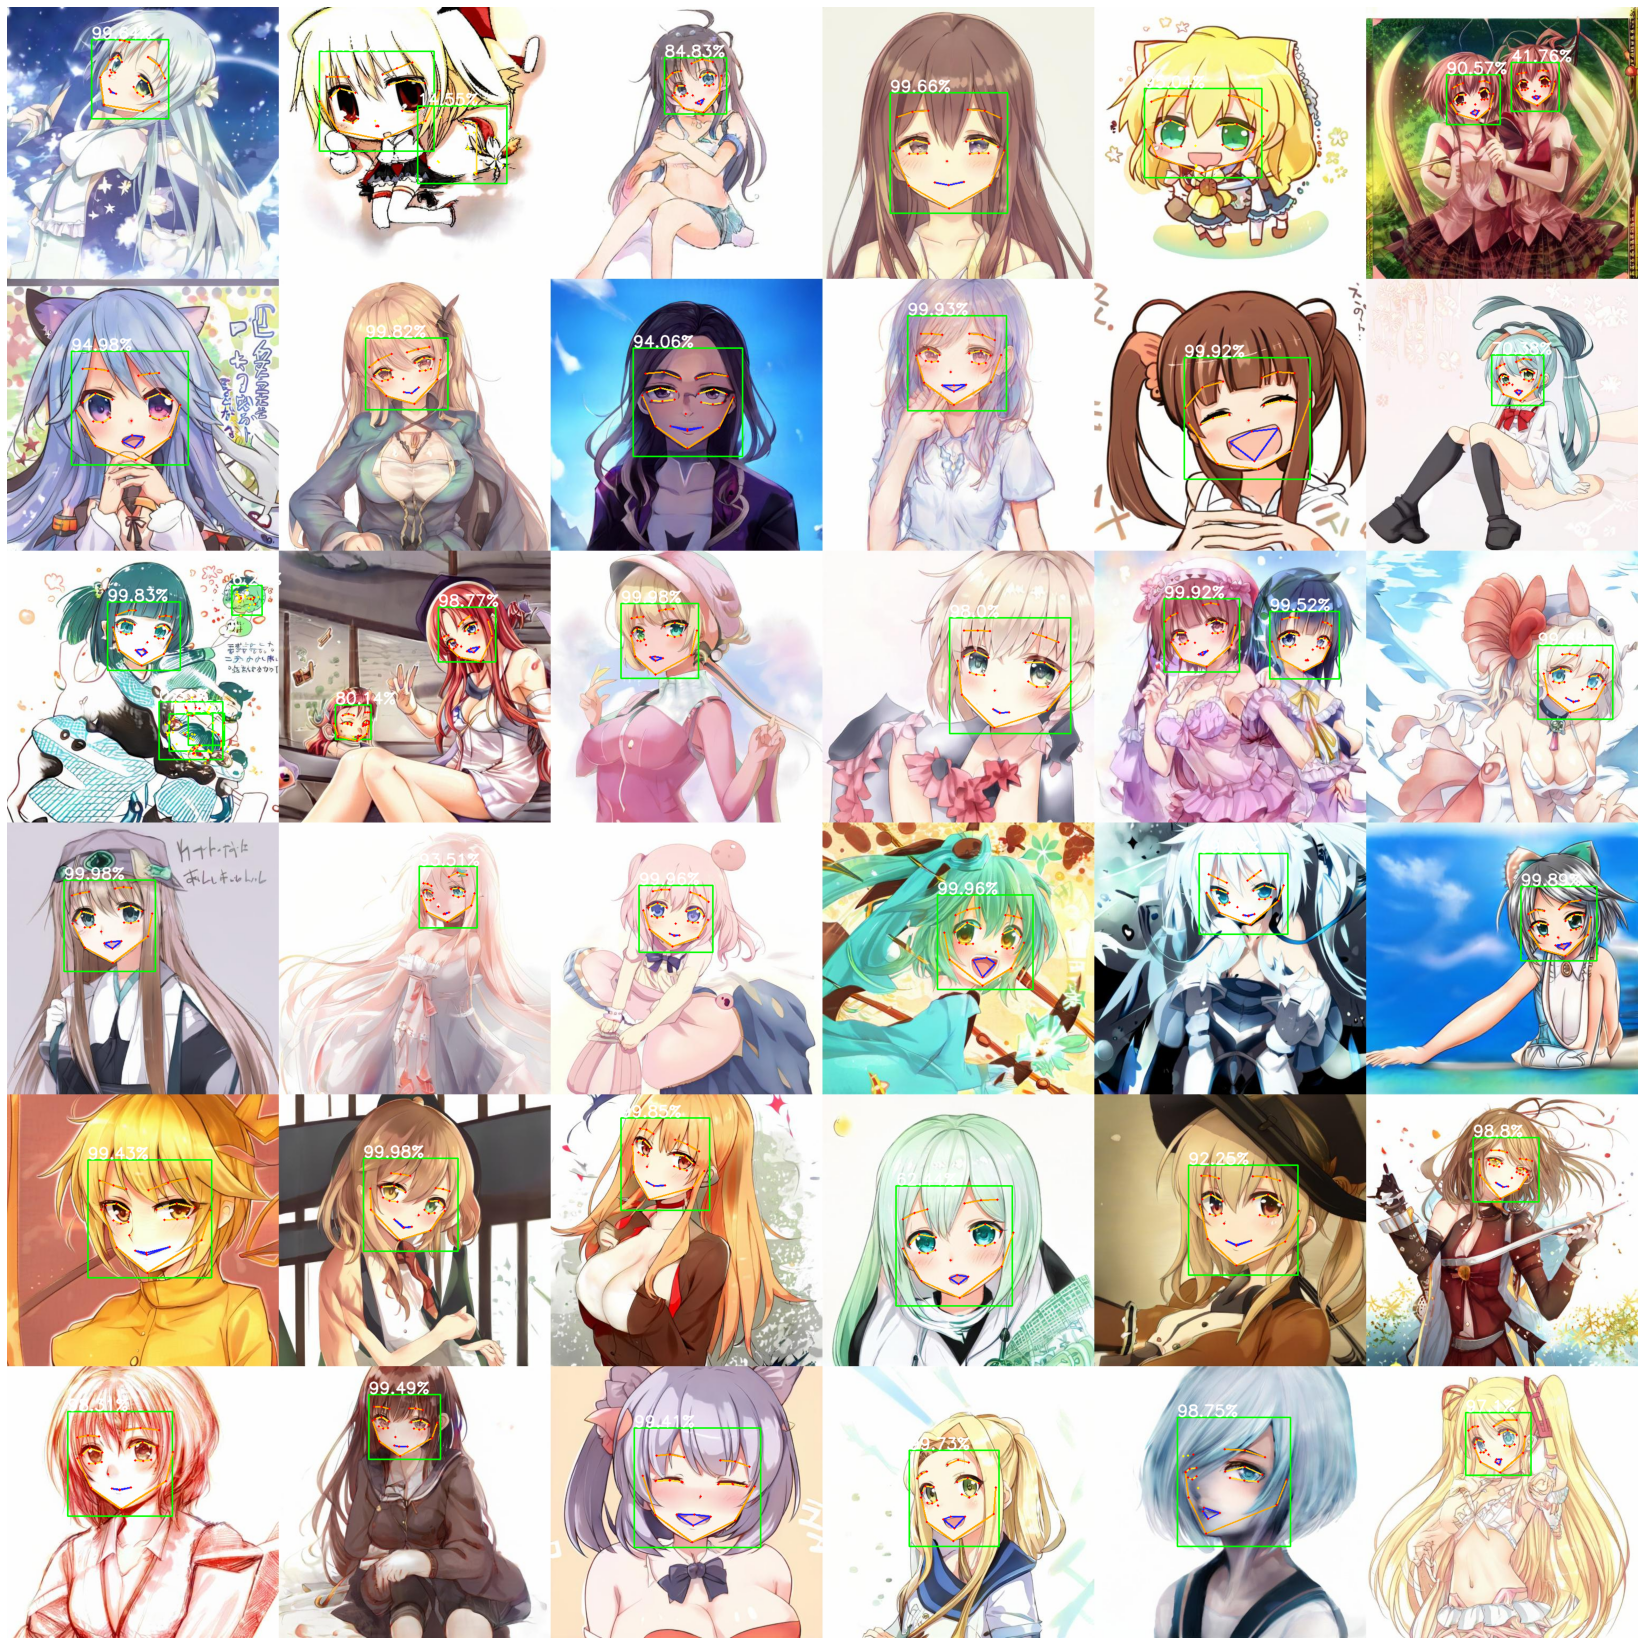

In [7]:
res = visualize(image, preds, face_score_threshold, landmark_score_threshold,
                show_box_score, draw_contour, skip_contour_with_low_score)

plt.figure(figsize=(30, 30))
plt.imshow(res[:, :, ::-1])
plt.axis('off')
plt.show()

# video test

In [8]:
# https://www.sakugabooru.com/post/show/43401
!wget -q https://www.sakugabooru.com/data/f47f699b9c5afc5a849be4b974f40975.mp4 -O input_vid.mp4

In [9]:
from moviepy.editor import VideoFileClip

# skip frame
speedx = 2
clip = VideoFileClip('input_vid.mp4').subfx(lambda c: c.speedx(speedx))
clip.write_videofile('input_vid_clip.mp4')
clip.close()

ModuleNotFoundError: No module named 'moviepy'

In [ ]:
from tqdm.auto import tqdm

cap = cv2.VideoCapture('input_vid_clip.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = cap.get(cv2.CAP_PROP_FPS) / speedx
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
writer = cv2.VideoWriter(
    filename='/content/anime-face-detector/output_vid.mp4',
    # some installation of opencv may not support x264 (due to its license),
    # you can try other format (e.g. MPEG)
    fourcc=cv2.VideoWriter_fourcc(*'MPEG'),
    fps=frames_per_second,
    frameSize=(width, height),
    isColor=True)

# Colab CPU 3.27s/it, Colab GPU 2.75it/s
with tqdm(total=num_frames) as pbar:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        pbar.update()
        preds = detector(frame)
        vis_frame = visualize(
            frame,
            preds,
            face_score_threshold=face_score_threshold,
            landmark_score_threshold=landmark_score_threshold,
            show_box_score=show_box_score,
            draw_contour=draw_contour,
            skip_contour_with_low_score=skip_contour_with_low_score)
        writer.write(vis_frame)

cap.release()
writer.release()

In [ ]:
!ffmpeg -i output_vid.mp4 -c:v libx264 -hide_banner -loglevel error -y out.mp4

In [ ]:
from IPython.display import HTML
from base64 import b64encode

HTML(f"""
<video height=400 controls loop>
  <source src="data:video/mp4;base64,{b64encode(open('out.mp4','rb').read()).decode()}" type="video/mp4">
</video>
""")